# Stocks Sentiment Analysis

***Goal:***
- To understand the sentiment from public tweets, which could be used as a factor while making a buy/sell decision of securities based on Recurrent Neural Networks (RNN) and Long Short Term Memory (LSTM)

***Result:***
- Overall accuracy 0.67 (total number of data 5791)
- f1-score for not flagged 0.65 and flagged 0.69 (number of not flagged data 4632  and number of flagged data 1159)

***Table of Content:***

0. Import Libearies and Dataset
1. Perform Exploratory Data Analysis
2. Perform Data Cleaning
3. Visualize Cleaned Up Dataset
4. Prepare The Data by Performing Tokenization and Padding
5. Build and Train The Model
6. Assess Trained Model Performance

<img src="PPT/Stocks Sentiment Analysis.png" width="1000">

Source: https://www.coursera.org/projects/natural-language-processing-for-stocks-news-analysis by Ryan Ahmed - Adjunct Professor

### 0. Import Libearies and Dataset

In [54]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 

In [2]:
# load the stock news data
stock_df = pd.read_csv('data/stock_sentiment.csv')

In [3]:
# Let's view the dataset. Sentiment = 1 if Positive comment, = 0 if Negative comment
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [4]:
# dataframe information
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


### 2. Perform Data Cleaning

In [5]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
# Let's define a function to remove punctuations
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [7]:
# create a new column 'Text Without Punctuations' in stock_df
stock_df['Text Without Punctuations'] = stock_df['Text'].apply(remove_punc) 

In [8]:
stock_df

,Text,Sentiment,Text Without Punctuations
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


In [9]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [10]:
stock_df['Text Without Punctuations'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2 see prev posts'

In [11]:
# download stopwords
nltk.download("stopwords")          # download list of stopwords
stopwords.words('english')          # show list of stopwords in English

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hoikinyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year'])    # manual extend additional stopwords into the list of stopwords

In [13]:
# Remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [14]:
# create a new column 'Text Without Punc & Stopwords' in stock_df and apply preprocess to the 'Text Without Punctuations' column
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuations'].apply(preprocess) 

In [15]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [16]:
stock_df['Text Without Punc & Stopwords'][0]

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts']

In [17]:
stock_df

,Text,Sentiment,Text Without Punctuations,Text Without Punc & Stopwords
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw..."
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop..."
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta]
4,OI Over 21.37,1,OI Over 2137,[]
...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s..."
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,..."
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri..."
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift..."


### 3. Visualize Cleaned Up Dataset

In [18]:
# combin the 'list' of all char under the column 'Text Without Punc & Stopwords' into a 'string' in new column 'Text Without Punc & Stopwords Joined'
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

<AxesSubplot:xlabel='count', ylabel='Sentiment'>

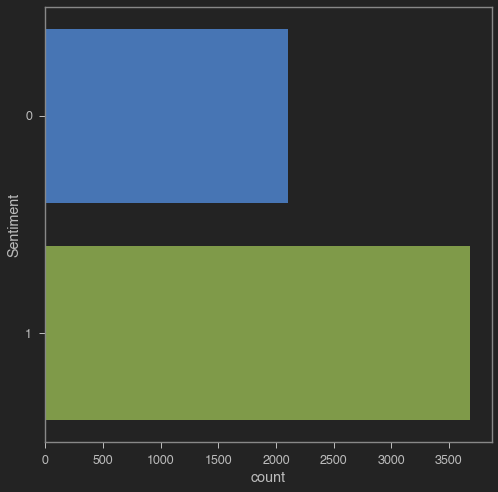

In [19]:
# plot the number of samples per each class
plt.figure(figsize = (8, 8))
sns.countplot(y = "Sentiment", data = stock_df)

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/hoikinyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
# word_tokenize is used to break up a string into words
print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [24]:
# count number of words in the column of stock_df['Text Without Punc & Stopwords Joined']
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]
tweets_length

[14,
 6,
 7,
 1,
 0,
 1,
 8,
 13,
 8,
 4,
 10,
 18,
 8,
 8,
 11,
 5,
 12,
 10,
 12,
 4,
 6,
 5,
 2,
 5,
 3,
 10,
 3,
 3,
 9,
 6,
 8,
 10,
 8,
 3,
 10,
 11,
 4,
 8,
 11,
 10,
 10,
 7,
 9,
 8,
 4,
 10,
 8,
 7,
 7,
 9,
 10,
 10,
 8,
 2,
 14,
 12,
 9,
 8,
 1,
 14,
 7,
 11,
 5,
 13,
 6,
 6,
 7,
 6,
 6,
 10,
 9,
 4,
 10,
 13,
 16,
 6,
 9,
 6,
 2,
 11,
 5,
 4,
 9,
 11,
 16,
 4,
 9,
 5,
 6,
 2,
 1,
 5,
 9,
 4,
 7,
 6,
 7,
 10,
 1,
 3,
 9,
 4,
 16,
 8,
 10,
 11,
 18,
 6,
 7,
 13,
 12,
 9,
 3,
 3,
 10,
 10,
 8,
 6,
 8,
 5,
 5,
 8,
 9,
 15,
 3,
 5,
 9,
 18,
 13,
 11,
 3,
 1,
 1,
 2,
 7,
 12,
 12,
 8,
 8,
 10,
 9,
 10,
 15,
 8,
 9,
 9,
 12,
 10,
 6,
 10,
 13,
 4,
 11,
 8,
 15,
 13,
 8,
 12,
 5,
 5,
 3,
 7,
 2,
 4,
 10,
 5,
 6,
 10,
 6,
 16,
 9,
 6,
 5,
 10,
 9,
 10,
 8,
 2,
 10,
 9,
 10,
 12,
 7,
 10,
 7,
 3,
 6,
 5,
 9,
 9,
 4,
 6,
 5,
 4,
 4,
 8,
 10,
 8,
 8,
 13,
 9,
 7,
 10,
 12,
 8,
 6,
 5,
 3,
 10,
 11,
 6,
 9,
 10,
 13,
 10,
 7,
 12,
 7,
 11,
 10,
 4,
 4,
 3,
 10,
 2,
 9,
 10,
 15,
 12,
 10

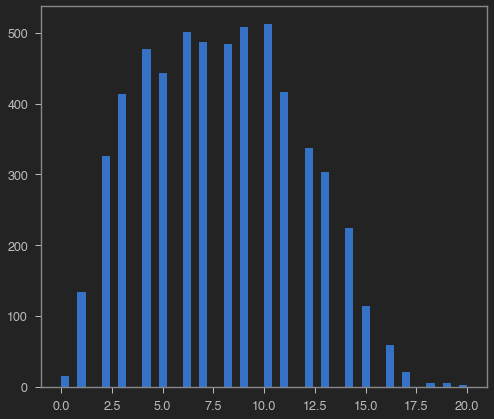

In [25]:
plt.hist(tweets_length, bins = 50)
plt.show()

### 4. Prepare The Data by Performing Tokenization and Padding

In [26]:
stock_df

,Text,Sentiment,Text Without Punctuations,Text Without Punc & Stopwords,Text Without Punc & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop...",afraid short amzn looking like nearmonopoly eb...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[],
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,...",gold prices slip investors book profits amid c...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


In [27]:
# Obtain the total words present in the dataset
list_of_words = []             # create a list_of_words

for i in stock_df['Text Without Punc & Stopwords']:

    for j in i:
        list_of_words.append(j)

In [28]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))        # use set(list_of_words) will only obtain unique words of (list_of_words)
total_words   

9268

In [29]:
# split the data into test and train 
X = stock_df['Text Without Punc & Stopwords']    # set input as X
y = stock_df['Sentiment']                        # set out as y

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [30]:
X_train.shape

(4632,)

In [31]:
X_test.shape

(1159,)

In [32]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [33]:
train_sequences

[[1742, 874, 82, 3374, 3375, 164, 3376],
 [222, 3377, 1393, 79, 1743, 1180, 875],
 [86, 89, 1394, 2274, 1395, 1744, 42, 1396, 876, 1397, 1003, 3378, 3379, 3380],
 [7, 3381],
 [877, 12, 878, 1745, 8, 50],
 [1004, 142, 402, 1005, 489, 33, 26, 79],
 [684, 1006, 353, 160, 295, 39, 625, 568],
 [3382, 165, 3383, 74, 767, 215, 371, 143, 13, 1181, 229, 1398],
 [768, 322, 1182, 3384, 107, 569, 39],
 [175, 570],
 [685],
 [296, 879, 130, 337],
 [3385, 223, 338, 103, 3386, 1183, 3387, 323, 1399, 51, 3388, 3389],
 [297, 3, 216, 43, 104, 131, 2, 1746],
 [354, 686, 297, 3390, 431, 3391],
 [626, 1184, 3392, 3393, 22, 66, 3394, 3395, 339, 3396, 3397, 3398],
 [44, 215, 24, 3399, 98],
 [108, 136, 461, 53, 880, 54, 99, 571, 1747, 2275],
 [6, 1, 70, 75, 100, 74, 71, 3400, 3401, 403, 340, 5, 490, 881],
 [1400, 627, 882, 404, 93, 117, 125, 3402, 1185, 1401, 3403, 3404, 1007],
 [49, 572],
 [1402, 12, 43, 80, 16, 169, 217],
 [462, 109, 110, 244, 190, 18, 8, 41, 109, 90],
 [1748, 5, 1748, 2276, 1008, 170, 71, 2

In [34]:
test_sequences

[[468, 30, 19],
 [1998, 3518, 35],
 [67, 200, 102, 1128, 109, 567, 929, 2522, 395, 95, 234],
 [6, 12, 500],
 [63, 884, 419, 705, 133, 1456, 1222, 1457, 790, 180],
 [465, 358, 81, 122, 1992, 216, 5, 11, 2, 13],
 [1147, 14],
 [131, 1773, 1030, 95, 25, 1448, 418, 1329, 1431, 475, 1381],
 [241, 20, 192, 4610, 4113],
 [280, 85, 42, 867, 1193, 777, 343],
 [477, 1418],
 [305, 79, 1350, 567, 929, 6357, 404, 79, 1350],
 [124, 2763, 1050, 414, 1366, 1719],
 [449, 97, 1287, 81],
 [55, 130, 199, 521, 48, 2909, 6003, 673, 4300, 23],
 [847, 1529, 7546, 1888],
 [22, 55, 567, 2434, 6056, 2268, 1087],
 [21, 921, 38, 27, 1071, 54, 715, 23],
 [1787, 3138, 2, 18],
 [360, 38, 67, 1, 107, 26, 902, 752, 35, 336, 189, 1091],
 [178],
 [175, 648, 879, 213, 1603, 462, 647],
 [1135, 782, 545, 24],
 [6509, 427, 3250, 202, 32],
 [1891, 12, 1],
 [11, 83, 125, 277, 15, 2, 301, 88, 1280, 5966, 2],
 [312, 804, 465, 562, 403, 111, 761, 356],
 [616, 36, 223],
 [434, 1219, 292, 7293, 577, 6642, 2656, 889, 483],
 [1108, 11

In [35]:
print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 2789    [nvda, zte, ship, first, tegra, phones, mid]
Name: Text Without Punc & Stopwords, dtype: object 
 is:  [222, 3377, 1393, 79, 1743, 1180, 875]


In [36]:
# Add padding to training and testing to ensure all data has same length = 15
padded_train = pad_sequences(train_sequences, maxlen = 15, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 15, truncating = 'post')

In [37]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [1742  874   82 3374 3375  164 3376    0    0    0    0    0    0    0
    0]
The padded encoding for document: 2  is: [ 222 3377 1393   79 1743 1180  875    0    0    0    0    0    0    0
    0]
The padded encoding for document: 3  is: [  86   89 1394 2274 1395 1744   42 1396  876 1397 1003 3378 3379 3380
    0]


In [38]:
# Convert the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [39]:
y_train_cat.shape

(4632, 2)

In [40]:
y_test_cat.shape

(1159, 2)

In [41]:
y_train_cat

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [45]:
# Sequential Model
model = Sequential()

# embedding layer
model.add(Embedding(total_words, output_dim = 512))     # feel free to play around the number of output_dim 

# Bi-Directional RNN and LSTM
model.add(LSTM(256))                                    # feel free to play around the number of LSTM

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 512)         4745216   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 5,565,826
Trainable params: 5,565,826
Non-trainable params: 0
_________________________________________________________________


In [46]:
# train the model
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 5)   # y_train_cat is label of padded_train data

Epoch 1/5
116/116 [==============================] - 24s 161ms/step - loss: 0.6086 - acc: 0.6831 - val_loss: 0.4927 - val_acc: 0.7670
Epoch 2/5
116/116 [==============================] - 19s 166ms/step - loss: 0.3160 - acc: 0.8753 - val_loss: 0.4969 - val_acc: 0.7756
Epoch 3/5
116/116 [==============================] - 17s 148ms/step - loss: 0.1770 - acc: 0.9420 - val_loss: 0.6309 - val_acc: 0.7627
Epoch 4/5
116/116 [==============================] - 18s 159ms/step - loss: 0.1024 - acc: 0.9673 - val_loss: 0.7393 - val_acc: 0.7681
Epoch 5/5
116/116 [==============================] - 19s 165ms/step - loss: 0.0749 - acc: 0.9779 - val_loss: 0.9437 - val_acc: 0.7389


### 6. Assess Trained Model Performance

In [47]:
# make prediction
pred = model.predict(padded_test)

In [48]:
# make prediction
prediction = []
for i in pred:
    prediction.append(np.argmax(i))

In [49]:
# list containing original values
original = []
for i in y_test_cat:
    original.append(np.argmax(i))

In [50]:
# acuracy score on text data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.6721311475409836

<AxesSubplot:>

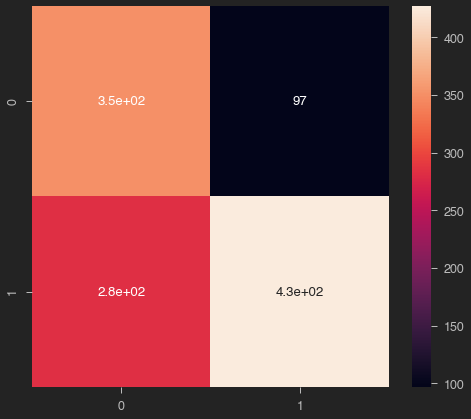

In [51]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)

In [56]:
# classification report
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       449
           1       0.81      0.60      0.69       710

    accuracy                           0.67      1159
   macro avg       0.68      0.69      0.67      1159
weighted avg       0.71      0.67      0.68      1159



***End of Page***